# **Customer Classification for Bank Marketing Campaign - Part 2** 🏢


**Table of content :**

0. Initial Setup
1. Exploratory Data Analysis
2. Data Preparation

****

## **Initial Setup**

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import missingno as msn
import math

import warnings
warnings.filterwarnings('ignore')

**Import and Merge Additional Dataset to Initial Dataset**

In [2]:
# import datasets
df1 = pd.read_csv('bank_marketing_campaign.csv', delimiter=';')
df2 = pd.read_csv('bank additional.csv')

# dropping duplicates in df1 (initial dataset) before merging
df1 = df1.drop_duplicates(keep='first', ignore_index=True)

# merging 
df = pd.merge(df1, df2, on=df1.columns.tolist(), how='left')

# saving to csv
df.to_csv('new_data.csv', index=False)

# checking shape
df.shape

# display dataframe
display(df.head(), df.tail())

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,marital,education,default,day,duration,previous
0,55,admin.,1662,no,no,cellular,jun,2,-1,unknown,yes,married,secondary,no,4,94,0
1,39,self-employed,-3058,yes,yes,cellular,apr,3,-1,unknown,yes,married,tertiary,no,17,882,0
2,51,admin.,3025,no,no,cellular,may,1,352,other,yes,married,secondary,no,7,476,1
3,38,services,-87,yes,no,cellular,may,1,-1,unknown,no,single,primary,no,13,531,0
4,36,housemaid,205,yes,no,telephone,nov,4,-1,unknown,no,married,secondary,no,18,176,0


,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit,marital,education,default,day,duration,previous
7813,62,housemaid,2,no,no,cellular,nov,1,-1,unknown,yes,married,secondary,no,3,322,0
7814,48,housemaid,5473,no,no,cellular,feb,2,184,success,yes,married,tertiary,no,24,127,2
7815,36,unknown,179,no,no,cellular,aug,8,-1,unknown,no,married,secondary,no,8,14,0
7816,31,admin.,54,yes,no,cellular,nov,1,-1,unknown,no,married,secondary,no,21,226,0
7817,60,retired,1588,no,no,cellular,oct,1,-1,unknown,yes,married,primary,no,6,728,0


In [3]:
numerical_columns = ['age', 'balance', 'campaign', 'pdays', 'duration', 'previous', 'day']
categorical_columns = ['job', 'housing', 'loan', 'contact', 'month', 'poutcome', 'marital', 'education', 'default']
target = ['deposit']

## **Exploratory Data Analysis**

### **Univariate Analysis**
#### **Numerical Columns**

<Figure size 1080x1080 with 0 Axes>

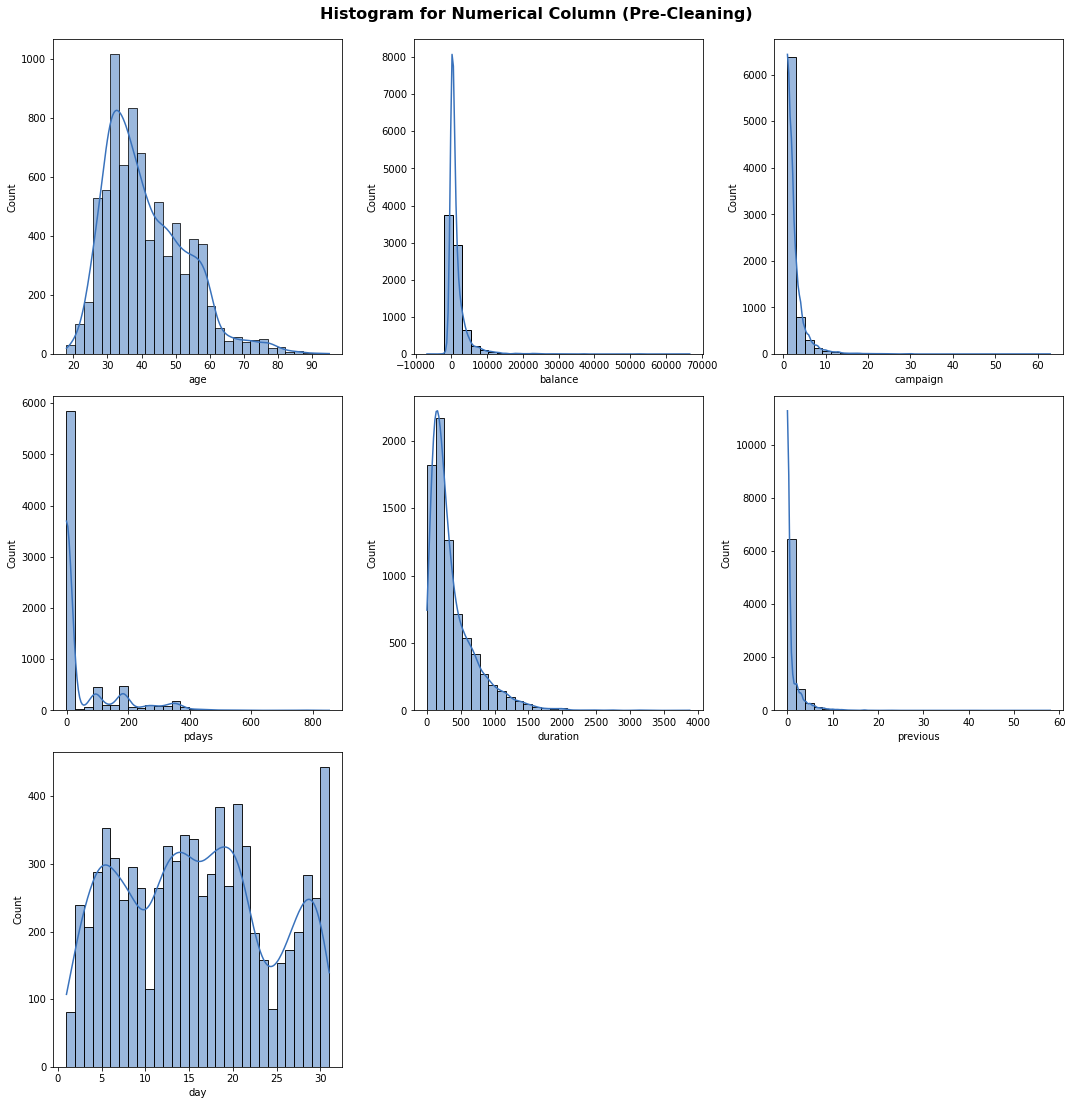

<Figure size 1080x1080 with 0 Axes>

In [4]:
plt.figure(figsize=(15, 15))
n = 3
for i in range(0, len(numerical_columns)):
    plt.subplot(n, math.ceil(len(numerical_columns)/n), i+1)
    sns.histplot(df[numerical_columns[i]], color='#3972bc', bins=30, kde=True)
    plt.tight_layout()

plt.suptitle('Histogram for Numerical Column (Pre-Cleaning)', fontsize=16, y=1.02, fontweight='bold')
plt.show

plt.figure(figsize=(15, 15))

In [5]:
from scipy.stats import skew
from scipy.stats import kurtosis

skew_type_list = []
skew_val_list = []
kurtosis_val_list = []

for column in numerical_columns:
    data = df[column].dropna(axis=0) 
    q1 = data.quantile(q=0.25)
    mean = round(data.mean(), 3)
    median = data.median()
    mode = data.mode()[0]
    q3 = data.quantile(q=0.75)
    # skew_val = round(data.skew(),3)
    skew_val = round(skew(data, nan_policy="omit"),3)
    kurtosis_val = round(kurtosis(data, nan_policy="omit"),3)

    if (mean == median == mode) or (-0.2 < skew_val < 0.2):
        skew_type = "Normal Distribution (Symmetric)"
    elif mean < median < mode:
        skew_type = "Negatively Skewed"
        if skew_val <= -1:
            skew_type = "Highly Negatively Skewed"
        elif -0.5 >= skew_val > -1:
            skew_type = "Moderately Negatively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    else:
        skew_type = "Positively Skewed"
        if skew_val >= 1:
            skew_type = "Highly Positively Skewed"
        elif 0.5 <= skew_val < 1:
            skew_type = "Moderately Positively Skewed"
        else :
            skew_type = "Moderately Normal Distribution (Symmetric)"
    skew_type_list.append(skew_type)
    skew_val_list.append(skew_val)
    kurtosis_val_list.append(kurtosis_val)
            
dist = pd.DataFrame({
    "Column Name":numerical_columns,
    "Skewness": skew_val_list,
    "Kurtosis": kurtosis_val_list,
    "Type of Distribution": skew_type_list
})

# for bimodial and Uniform

dist.loc[dist["Column Name"].isin(["Z_CostContact", "Z_Revenue"]), "Type of Distribution"] = "Uniform Distribution"
dist.loc[dist["Column Name"].isin(["Kidhome", "Teenhome"]), "Type of Distribution"] = "Bimodal Distribution"
dist

,Column Name,Skewness,Kurtosis,Type of Distribution
0,age,0.868,0.625,Moderately Positively Skewed
1,balance,6.761,80.238,Highly Positively Skewed
2,campaign,5.539,59.929,Highly Positively Skewed
3,pdays,2.412,6.570,Highly Positively Skewed
4,duration,2.169,7.576,Highly Positively Skewed
5,previous,7.935,118.433,Highly Positively Skewed
6,day,0.123,-1.049,Normal Distribution (Symmetric)


**Insight:**

From the observation of box plot charts and histograms, it can be seen that almost all variables have outliers, except for the 'day' variable. Furthermore, it is known that the majority of the variable distributions are positively skewed. To handle skewness, robust scaling will be used.

#### **Categorical Columns**

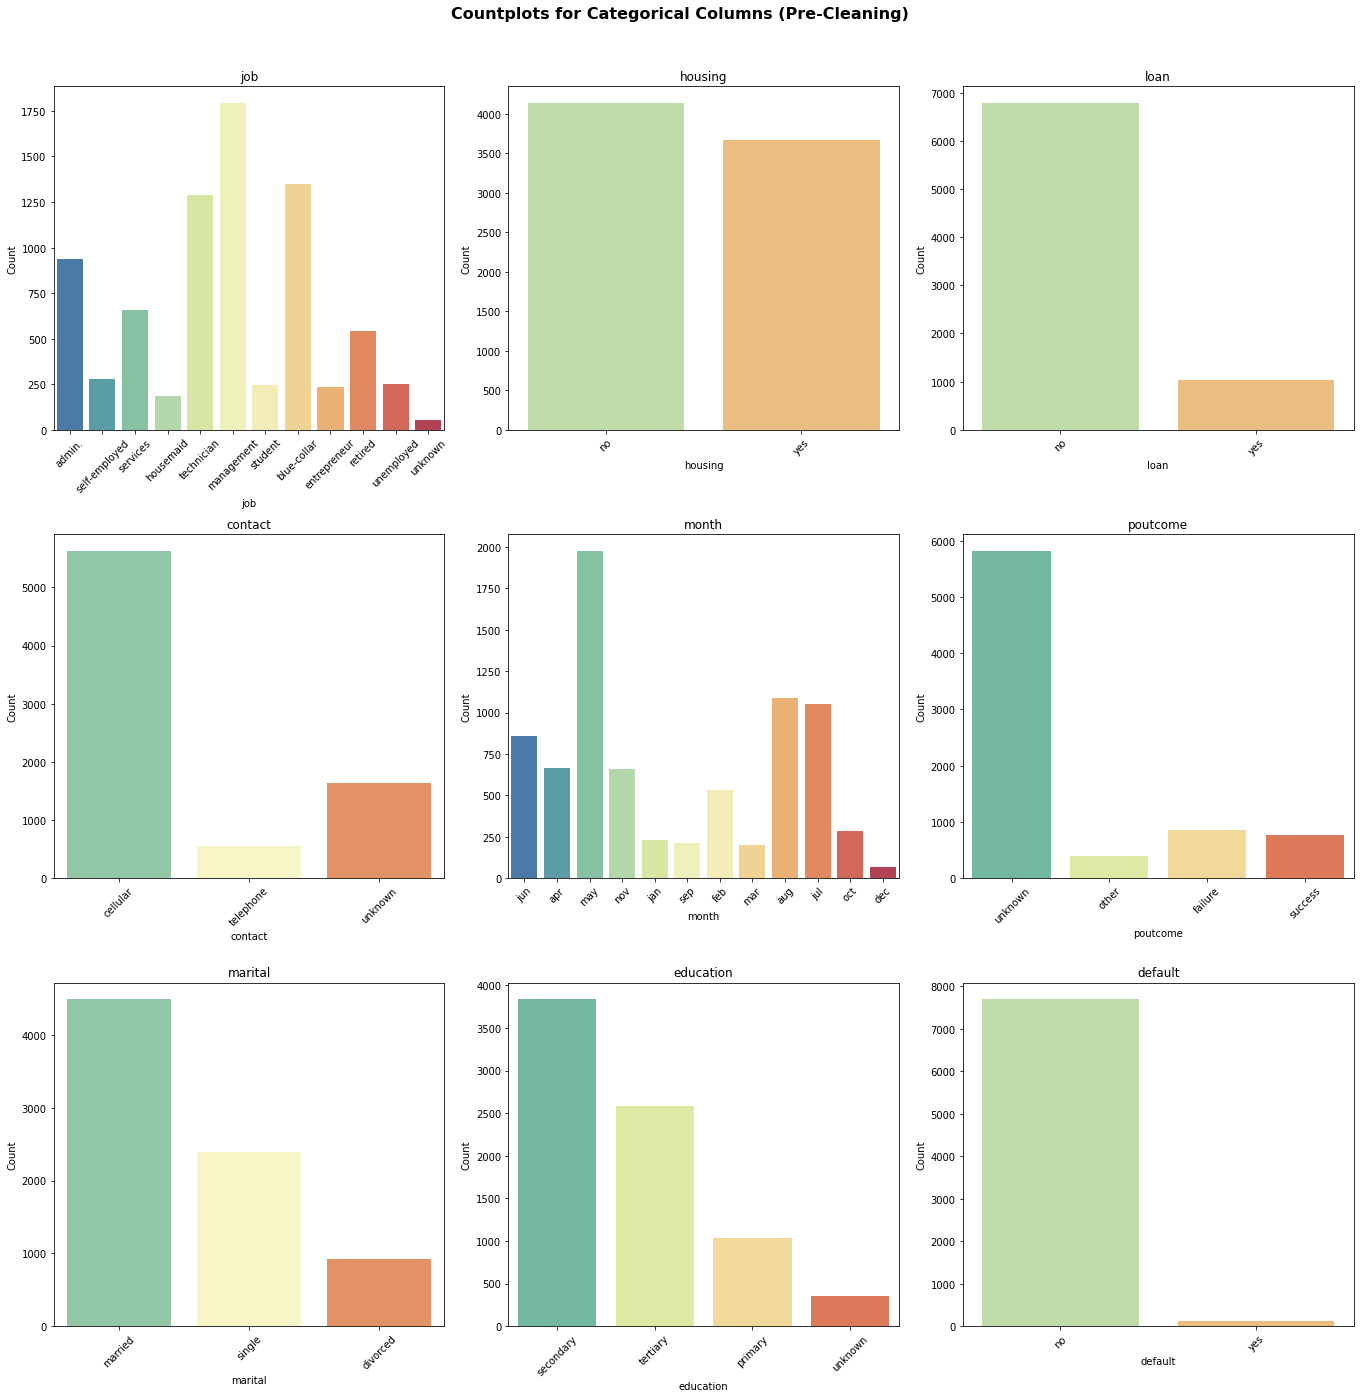

In [6]:
cat_cols = categorical_columns.copy()


plt.figure(figsize=(19, 19))
n = 3
for i, column in enumerate(cat_cols):
    plt.subplot(n, math.ceil(len(cat_cols)/n), i+1)
    bar_plot=sns.countplot(x=column, data=df, palette='Spectral_r')
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45)
    plt.title(column)
    plt.ylabel('Count')

plt.suptitle('Countplots for Categorical Columns (Pre-Cleaning)', fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

### **Bivariate Analysis**

#### **Demographic Datas & Target**


The analysis of demographic data and the target variable aims to understand the relationship between demographic factors and term deposit investment behavior. This helps the bank recognize the demographic profiles of potential customers.

- **Job vs Deposit**

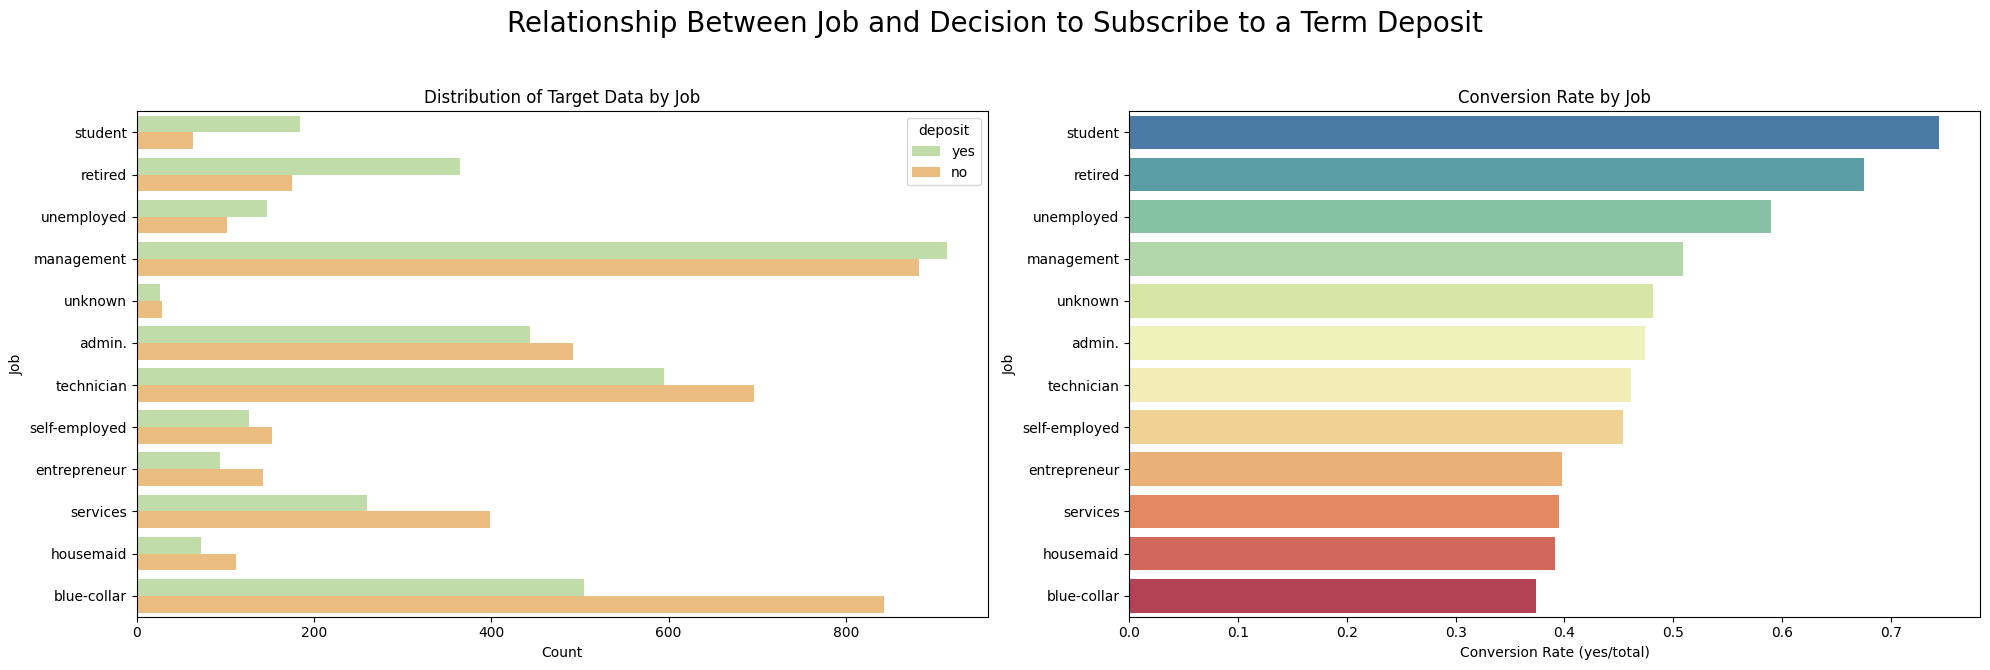

In [7]:
def crosstab_deposit(df, column_name):
    crosstab = pd.crosstab(df[column_name], df['deposit'])
    crosstab['conversion_rate'] = crosstab['yes'] / (crosstab['yes'] + crosstab['no'])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7), dpi=100)
    plt.suptitle(f'Relationship Between {column_name.capitalize()} and Decision to Subscribe to a Term Deposit', size=20)

    # Distribution of target data based on the column
    sns.countplot(hue='deposit', y=column_name, data=df, palette='Spectral_r', ax=axes[0],
                  order=crosstab.sort_values('conversion_rate', ascending=False).index)
    axes[0].set_title(f'Distribution of Target Data by {column_name.capitalize()}')
    axes[0].set_ylabel(column_name.capitalize())
    axes[0].set_xlabel('Count')

    # Conversion rate by the column
    sns.barplot(x='conversion_rate', y=crosstab.index, data=crosstab.reset_index(),
                palette='Spectral_r', ax=axes[1], order=crosstab.sort_values('conversion_rate', ascending=False).index)
    axes[1].set_title(f'Conversion Rate by {column_name.capitalize()}')
    axes[1].set_xlabel('Conversion Rate (yes/total)')
    axes[1].set_ylabel(column_name.capitalize())

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage: 
crosstab_deposit(df, 'job')


**Insight:**

- Different jobs have varying rates of investing in term deposits, suggesting a job's influence on someone's investment decisions.

- Unique trends show students, retirees, and the unemployed, presumably without steady income, have higher conversion rates compared to other jobs with fixed incomes like marketing, admin, and technicians. This could be because their investment funds come from savings. Without regular income, they prefer investing in stable, low-risk interest-bearing options.

- People with steady jobs such as management, admin, and technicians show less interest in term deposits, likely because a regular income allows them the flexibility to pursue higher-return, higher-risk investments.

- Self-employed individuals have similar conversion rates to office workers, indicating alike investment behaviors towards term deposits.
- Service workers, housemaids, and blue-collar workers have lower conversion rates, which could be due to lower income levels or less financial literacy.

- **Education vs Deposit**

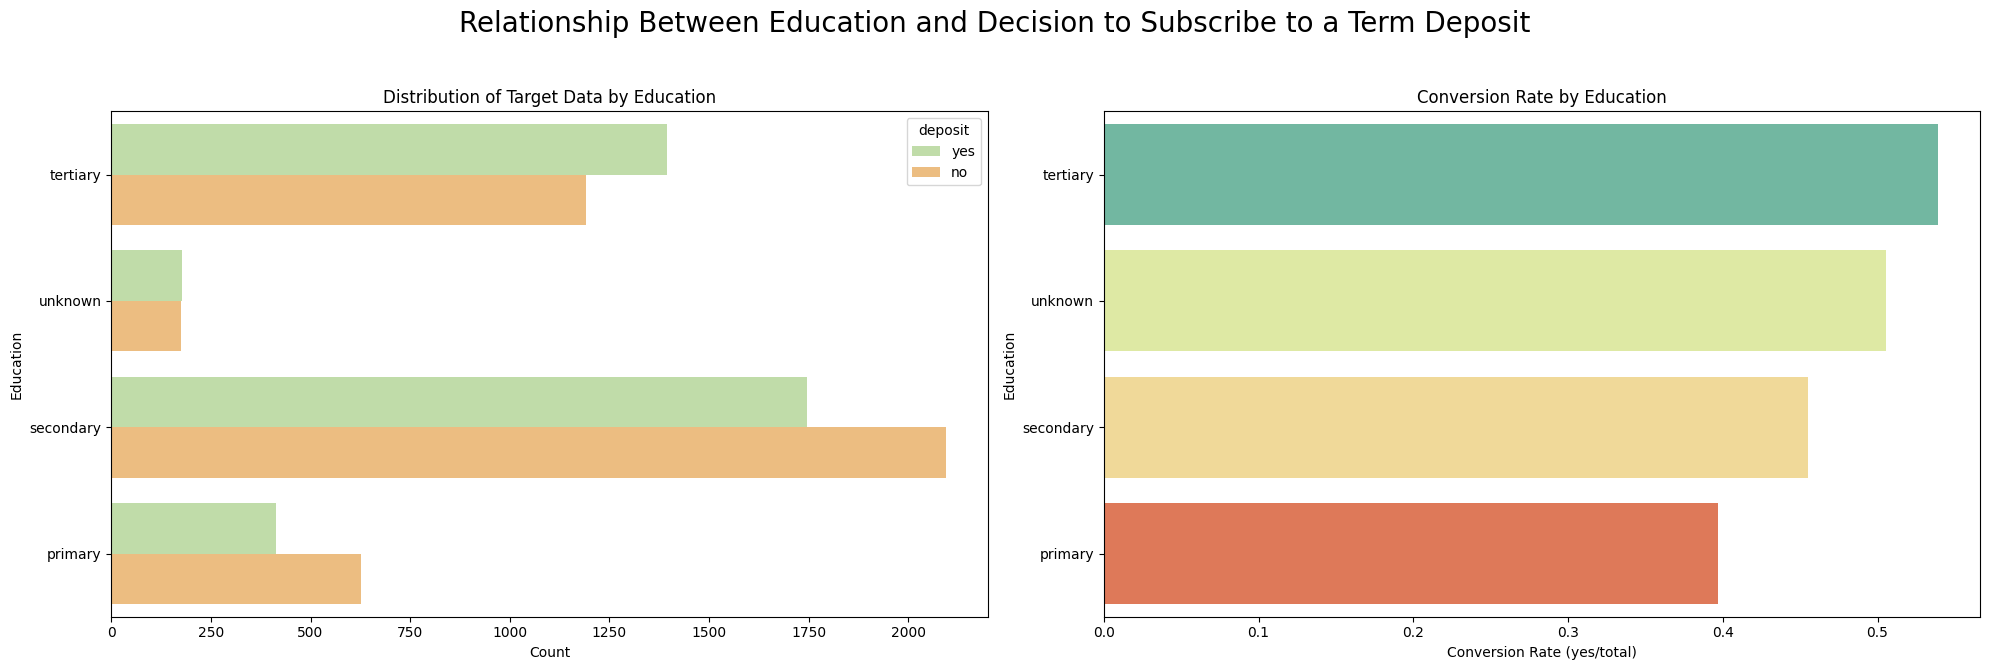

In [8]:
crosstab_deposit(df, 'education')

**Insight:**

- The higher the level of education, the higher the conversion rate to term deposits. This can be due to factors like income level, investment preference, financial knowledge, and access to information.

- **Marital vs Deposit**

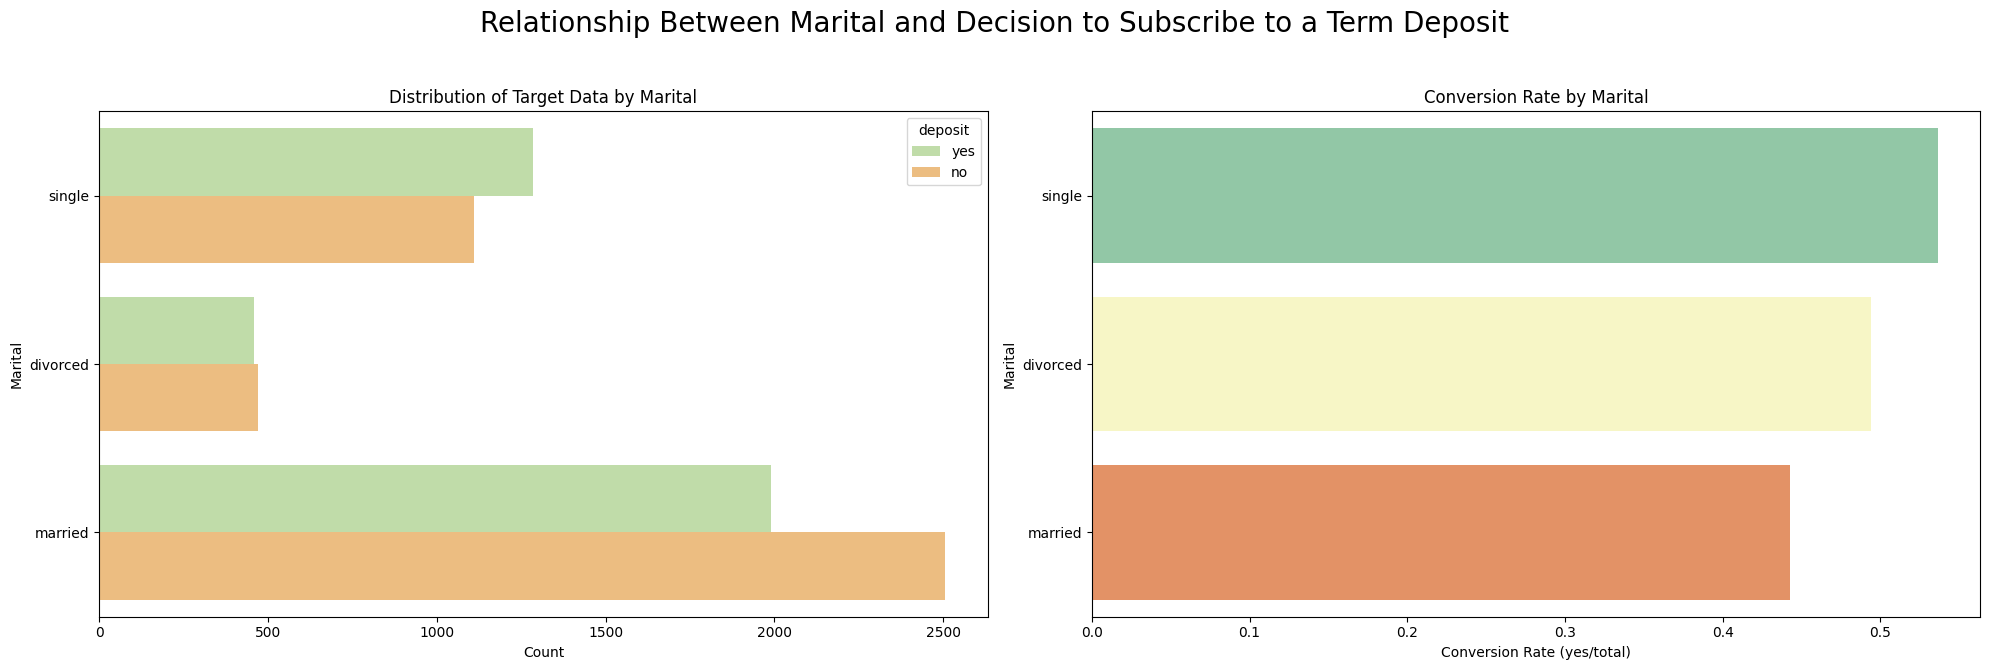

In [9]:
crosstab_deposit(df, 'marital')

**Insight:**

- Different marital statuses have different conversion rates, indicating that marital status can influence a person's investment behavior. 

- Single individuals have a higher conversion rate, possibly because they have more freedom to use their income or savings for investments due to not having household responsibilities.

- Among customers with a single marital status, the number of customers who invest in term deposits is higher than those who do not. Therefore, the bank should pay more attention to the potential of single customers.

- **Age vs Deposit**

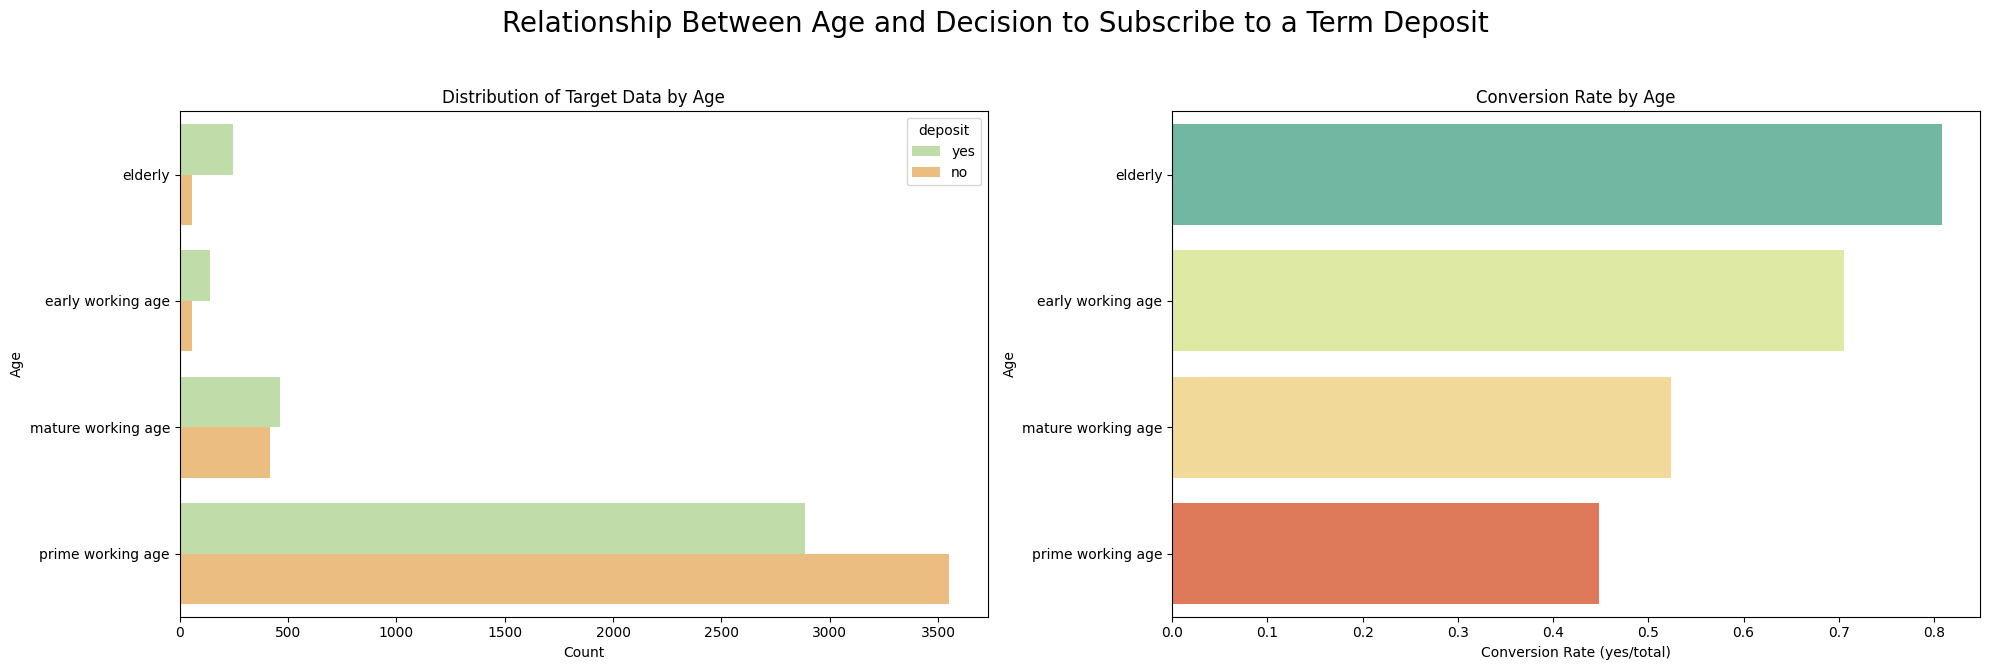

In [10]:
df_n = df.copy()
bins = [0, 14, 24, 54, 64, np.inf]
labels = ['children', 'early working age', 'prime working age', 'mature working age', 'elderly']
df_n['age'] = pd.cut(df_n['age'], bins=bins, labels=labels, right=True)

crosstab_deposit(df_n, 'age')

**Insight:**

- The elderly have the highest conversion rate, possibly because the money they invest comes from their savings. Therefore, they prefer long-term investments with fixed interest rates and low risk.

- Early working-age individuals have a higher conversion rate for term deposits compared to mature and prime working-age groups. This could be because, at this age, their income level is relatively low, leading them to choose low-risk investment options.

- Prime and mature working-age individuals have a low conversion rate, possibly because with their higher income levels, they have more flexibility to choose other types of investments.

- Among the four age categories, only the prime working-age category has a lower number of customers investing in term deposits compared to those who do not. Considering the large number of customers in this category and their potential, the bank can intensify its campaigns targeting prime working-age customers.

#### **Financial Datas & Target**


Financial data is the historical financial records of a customer, including home loans, debts, and defaults. By understanding the connection between a customer's financial records and the target variable, the bank can identify potential customers and those who may not be potential based on their financial history.

- **Loan vs Deposit**

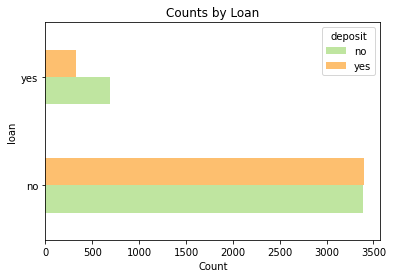

deposit,loan,no,yes,conversion_rate
0,no,3392,3402,0.500736
1,yes,694,330,0.322266


In [11]:
def ct_binary(df, column_name):
    # Crosstab for count plot
    count_crosstab = pd.crosstab(df[column_name], df['deposit'])
    ax = count_crosstab.plot(kind='barh', color=sns.color_palette('Spectral_r', len(count_crosstab.columns)))
    ax.set_title(f'Counts by {column_name.capitalize()}')
    ax.set_xlabel('Count')
    plt.show()

    # Crosstab for conversion rate
    conversion_crosstab = count_crosstab.assign(
        conversion_rate=lambda x: x['yes'] / (x['yes'] + x['no'])
    ).reset_index()

    return conversion_crosstab

ct_binary(df, 'loan')

**Insight:**

- Customers with loans tend to have a lower conversion rate. This indicates that the presence or absence of loans can influence a person's investment behavior.

- People with loans, especially consumptive loan, tend to have a lower inclination to invest or may not invest at all.

- **Housing vs Deposit**

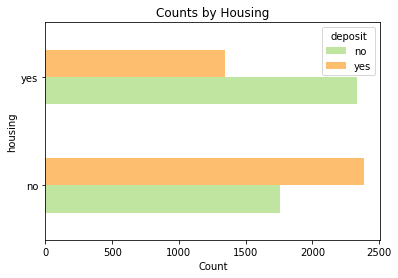

deposit,housing,no,yes,conversion_rate
0,no,1754,2389,0.576635
1,yes,2332,1343,0.365442


In [12]:
ct_binary(df, 'housing')


**Insight:**

- Individuals with home loans have a lower conversion rate. This suggests that the presence or absence of a home loan can impact a person's investment behavior.

- Among customers without home loans, the number of those who invest in term deposits is significantly higher compared to those who do not invest in term deposits. This indicates that individuals without home loans are potential customers who deserve attention in the bank's campaigns.



- **Default vs Deposit**

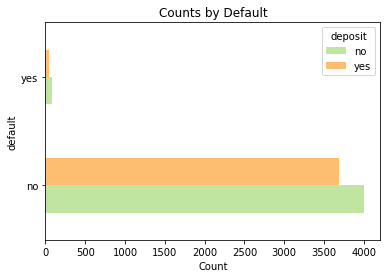

deposit,default,no,yes,conversion_rate
0,no,4006,3692,0.479605
1,yes,80,40,0.333333


In [13]:
ct_binary(df, 'default')

**Insight:**

- Individuals who default tend to have a lower conversion rate compared to those who do not default. This makes sense because customers who fail to make payments can be assumed to be experiencing financial difficulties, which means they have limited funds available for deposits.

#### **Campaign Datas & Target**

Campaign data relates to the records of campaign efforts conducted by the bank, such as timing, duration, and contacts. By comparing campaign data with the target, it is expected to provide insights into the aspects of the campaign that support customers in investing in term deposits and those that may be less supportive. Understanding the correlation between campaign aspects and the target variable allows the bank to devise strategies to strengthen aspects of the campaign that are correlated with the target

- **Month vs Deposit**

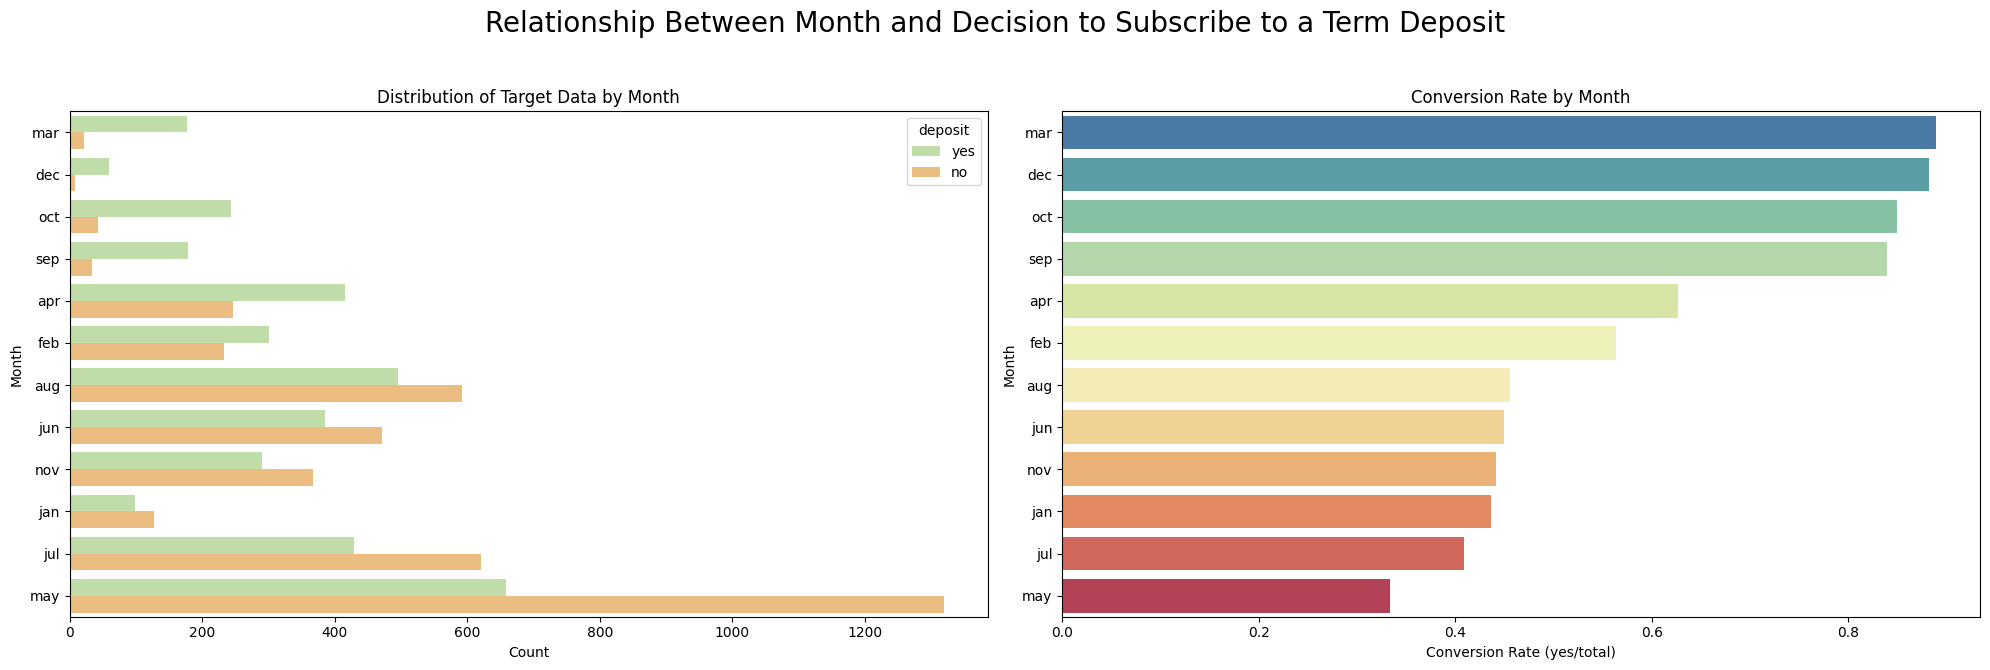

In [14]:
crosstab_deposit(df, 'month')

**Insight:**

- The month with the highest conversion rate is March, followed by December, October, and September. However, when looking at the data, the number of customers contacted in these months is lower than in other months. Additionally, the number of customers investing in term deposits is significantly higher than those who do not. This indicates the presence of a more efficient telemarketing pattern in these months, even though the overall number of contacts is lower compared to other months.

- The month with the highest number of customers investing in term deposits is May. However, because in the same month, the number of customers contacted who do not invest in term deposits is much higher, the conversion rate for that month is low.

- By considering the number of customers contacted in May, the bank appears to apply a strategy of contacting as many customers as possible to attract as many term deposit investors as possible. However, due to the lack of accurate prediction, this approach leads to inefficiencies by contacting many non-potential customers. In cases like this, a classification model is needed.


- **Poutcome vs Deposit**

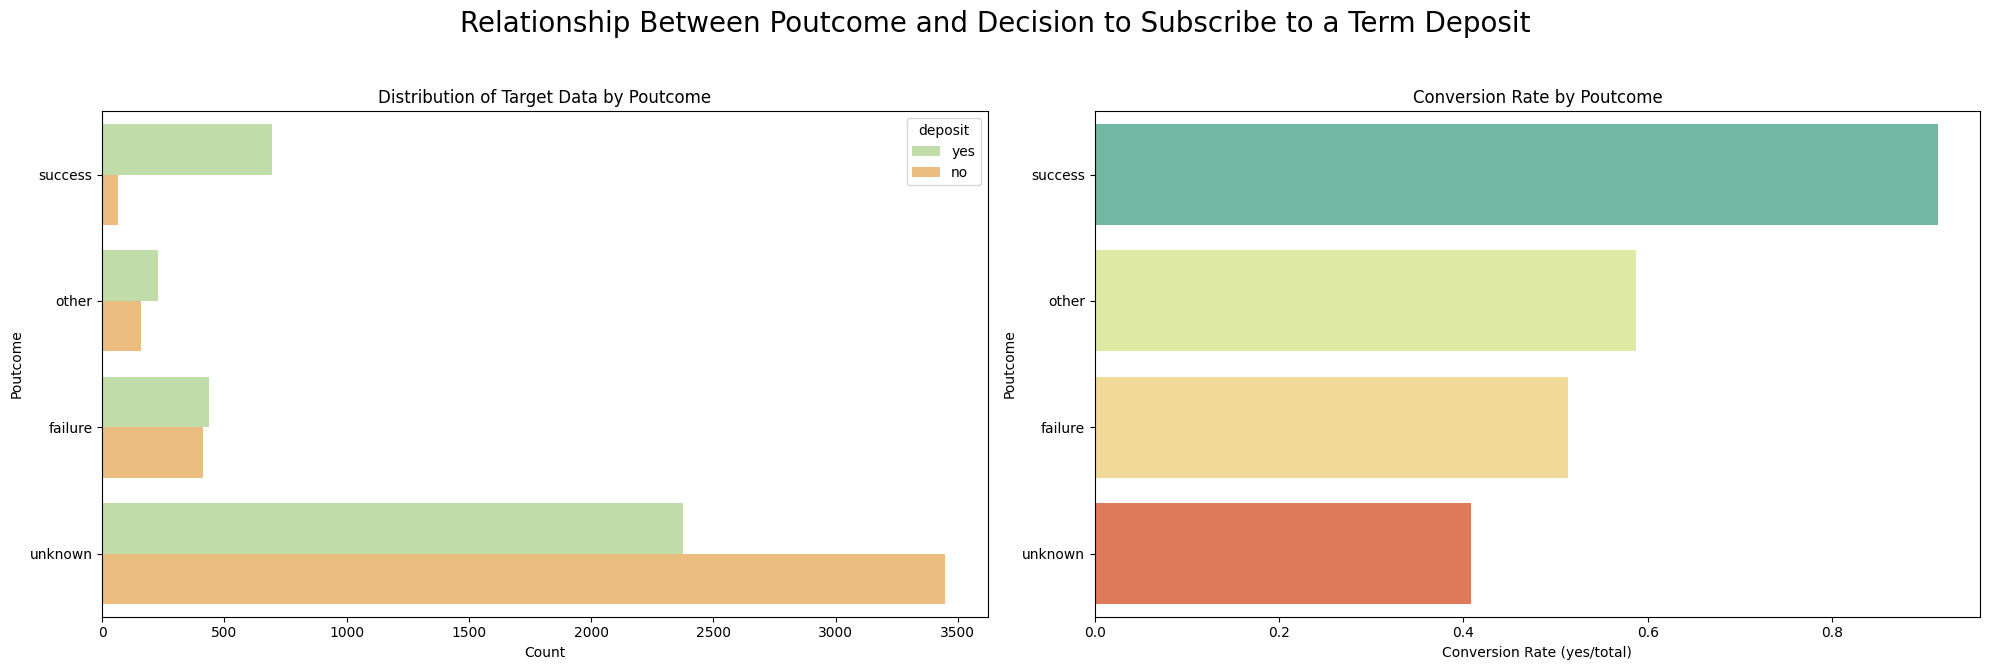

In [15]:
crosstab_deposit(df, 'poutcome')

**Insight:**


- Customers with a previous successful outcome have a significantly higher conversion rate compared to other outcome categories. This should prompt the bank to develop a strategy to increase successful outcomes in each campaign.

- In the "other" and "failure" categories, the number of customers investing in term deposits is slightly higher than those who do not. This indicates that even if the previous campaign outcome was a failure, there is still a possibility that these customers may be willing to invest. Therefore, regardless of a campaign's failure with a customer, the bank should consider maintaining communication if the customer is potentially interested.

- The "unknown" category significantly exceeds other categories in terms of quantity. To gain insights from this large number of customers, the bank should improve its data management to minimize the amount of unknown data. 

- **Contact vs Deposit**

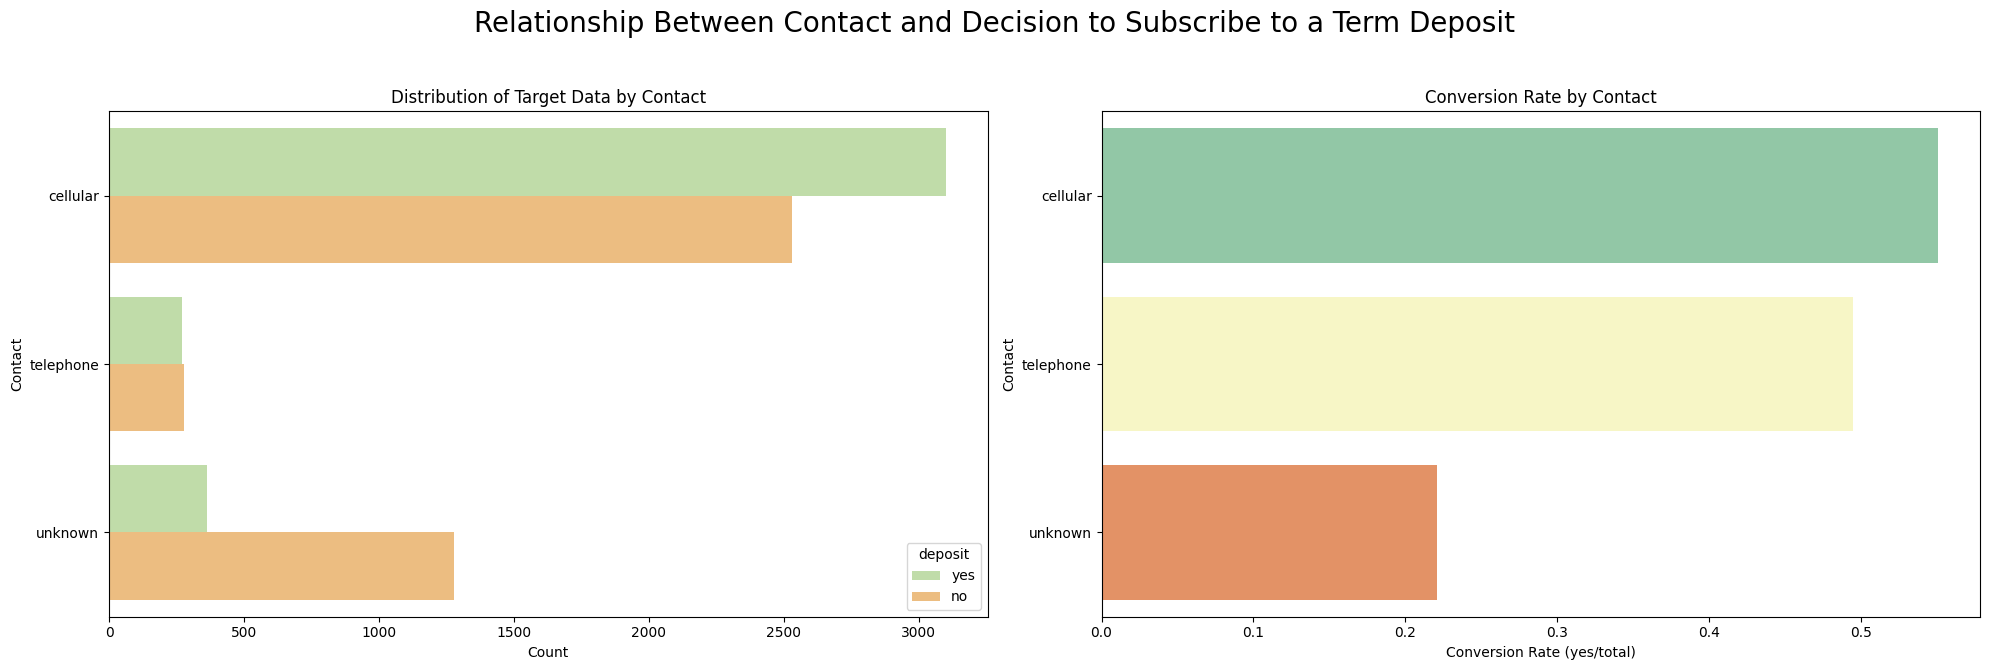

In [16]:
crosstab_deposit(df, 'contact')

**Insight:**

- The conversion rate for cellular calls is higher compared to other methods. This could be because most people are now more accustomed to talking on their cell phones. Additionally, the chances of a call being answered are higher because people always carry their cell phones. In this regard, the bank needs to maintain and further develop the cellular contacts it already has for campaign purposes.

- The difference between customers investing in term deposits and those not investing through phone contact is minimal. This suggests that phone contact remains a viable method, especially for customers who prefer it. For efficiency, the bank also needs to determine the contact preferences of its customers to tailor its approach accordingly.

- The "unknown" category is still quite large. The bank needs to improve data management to minimize the presence of the "unknown" category and extract insights from it.

### **Feature Correlation**


Correlation is performed to examine the relationships between the feature to the target

In [17]:
df1 = df.copy()
month_mapping = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}
poutcome_mapping = {'unknown': 0, 'other': 1, 'failure': 2, 'success': 3}
binary_mapping = {'yes' : 1, 'no' : 0}


df1['month'] = df1['month'].replace(month_mapping)
df1['poutcome'] = df1['poutcome'].replace(poutcome_mapping)
df1['housing'] = df1['housing'].replace(binary_mapping)
df1['loan'] = df1['loan'].replace(binary_mapping)
df1['deposit'] = df1['deposit'].replace(binary_mapping)
df1['default'] = df1['default'].replace(binary_mapping)

df_encoded = pd.get_dummies(df1, columns=['job', 'contact', 'marital'])

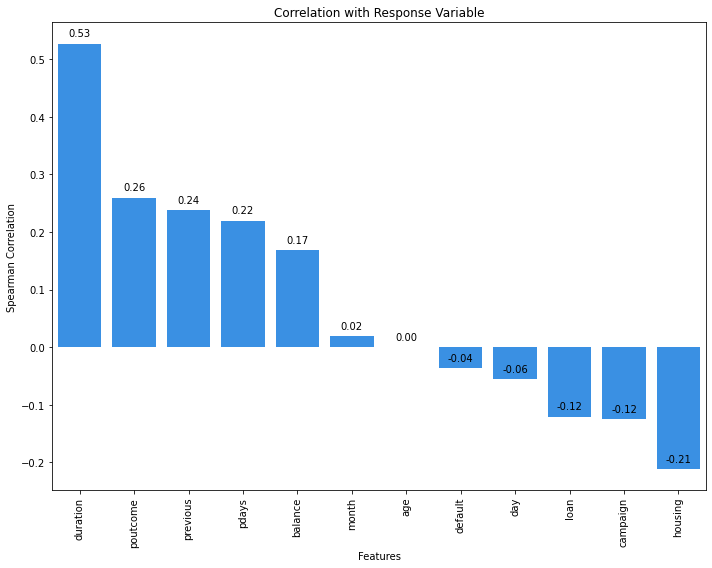

In [18]:
correlation = df1.corr(method='spearman')['deposit'].reset_index()
correlation.columns = ['feature', 'corr_value']
correlation = correlation.sort_values(by='corr_value', ascending=False)

correlation = correlation[correlation['feature'] != 'deposit']

plt.figure(figsize=(10, 8))
ax = sns.barplot(x='feature', y="corr_value", data=correlation, color='dodgerblue')

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.2f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points',
        fontsize=10
    )

plt.xticks(rotation=90)
plt.title('Correlation with Response Variable')
plt.ylabel('Spearman Correlation')
plt.xlabel('Features')
plt.tight_layout()  
plt.show()


**Insight:**

- From the Spearman correlation above, it can be observed that the target column has relatively low relationships with other features.

- The variable age, which was initially expected to have a correlation, is found to be uncorrelated with the target.

- Duration has the moderate correlation, while the correlations of other features with the target are weak. When processing the data, it is important to pay attention to duration data especially when using algorithm that senstivie to multicollinearity such as linear regression.

- In terms of financial data, housing has the highest correlation.




## **Data Preparation**

* Identifikasi dan kuantifikasi masalah yang ada dalam data seperti:
    1. Missing value
    2. Duplicated value
    3. Outlier
    4. Type data
    5. Column name
    6. Rare label
    7. Cardinality
    8. Collinearity
* Lakukan penanganan terhadap masalah data yang ditemukan.
* Lakukan feature engineering seperti:
    1. Encoding
    2. Scaling
    3. Feature creation
    4. Feature selection
* Buatlah pipeline dari tahap ini.

### **Problem Identification**

#### **1. Checking Data Type, Missing Value, and Duplicate**

In [19]:
# checking the data
print(f'The number of rows and columns in this dataset are: {df.shape}')

pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null_value(%)': df.isna().mean().values * 100,
    'n_unique': df.nunique().values,
    '0_value': [True if df[col].dtype == int and (df[col] == 0).any() else False for col in df.columns],
    'duplicate' : df.duplicated().sum()})

The number of rows and columns in this dataset are: (7818, 17)


,feature,data_type,null_value(%),n_unique,0_value,duplicate
0,age,int64,0.0,75,False,0
1,job,object,0.0,12,False,0
2,balance,int64,0.0,3153,False,0
3,housing,object,0.0,2,False,0
4,loan,object,0.0,2,False,0
5,contact,object,0.0,3,False,0
6,month,object,0.0,12,False,0
7,campaign,int64,0.0,32,False,0
8,pdays,int64,0.0,422,False,0
9,poutcome,object,0.0,4,False,0


<AxesSubplot:>

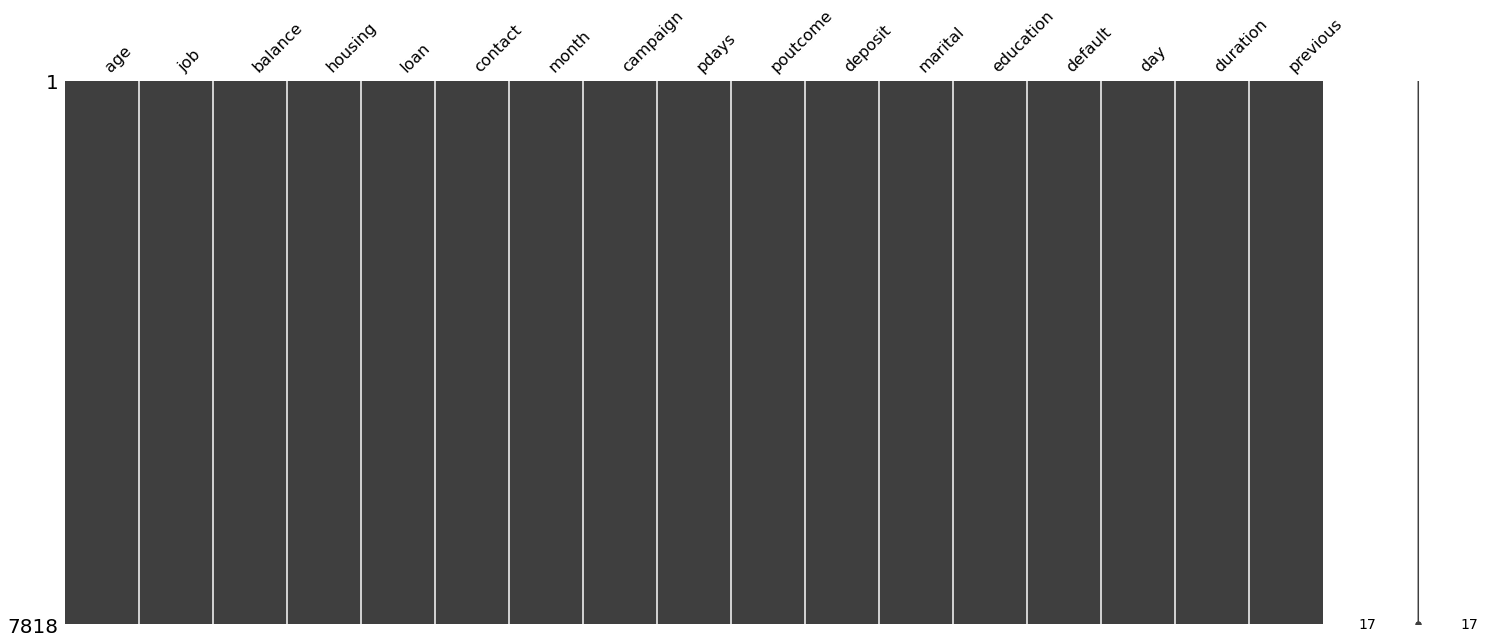

In [20]:
msn.matrix(df)

**Insight:**

- The data types in each column are already appropriate.

- No missing values were found.

- No duplicate data was found because duplicate data was already handled during the merging process with the new data.

#### **2. Checking Unique Value and Unknown Data**

In [21]:
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df.columns : 
    listItem.append( [col, df[col].nunique(), df[col].unique()])

tableDesc = pd.DataFrame(columns = ['Column Name', 'Number of Unique', 'Unique Sample'], 
                         data=listItem)
tableDesc

,Column Name,Number of Unique,Unique Sample
0,age,75,"[55, 39, 51, 38, 36, 41, 37, 35, 57, 23, 33, 31, 53, 30, 46, 48, 25, 29, 28, 52, 49, 44, 42, 27, 47, 64, 26, 34, 56, 32, 58, 45, 54, 50, 79, 65, 40, 24, 60, 43, 61, 59, 62, 68, 82, 71, 73, 76, 69, 20, 72, 22, 67, 19, 70, 75, 63, 93, 77, 80, 66, 21, 87, 81, 92, 88, 84, 83, 78, 74, 18, 85, 95, 86, 90]"
1,job,12,"[admin., self-employed, services, housemaid, technician, management, student, blue-collar, entrepreneur, retired, unemployed, unknown]"
2,balance,3153,"[1662, -3058, 3025, -87, 205, -76, 4803, 911, 805, 0, 1234, 1107, 1170, 341, 4808, 88, 169, 863, 242, 2597, 4929, 277, 1438, 15, 3733, 204, 1684, 1025, 55, 19, 348, 785, 742, 511, 6651, 1612, 555, 54, 1185, 110, 950, 412, 228, 367, 3993, 2599, 3528, 32, 551, 3161, 533, 8725, 349, 514, 2688, -194, 154, 874, 2, 5953, 1269, -327, 235, 7, 2661, 1948, 20, 502, 193, 13658, 1716, 172, 1667, 157, 8, 951, 427, 241, 469, 2060, 7177, 655, -114, 588, -971, 4570, 250, 131, 93, 22, 15341, 356, 190, -124, 2228, -60, 376, 1567, 855, 4151, ...]"
3,housing,2,"[no, yes]"
4,loan,2,"[no, yes]"
5,contact,3,"[cellular, telephone, unknown]"
6,month,12,"[jun, apr, may, nov, jan, sep, feb, mar, aug, jul, oct, dec]"
7,campaign,32,"[2, 3, 1, 4, 5, 6, 7, 30, 8, 9, 11, 14, 10, 28, 63, 12, 24, 17, 15, 18, 19, 13, 21, 23, 22, 33, 16, 25, 26, 20, 29, 43]"
8,pdays,422,"[-1, 352, 21, 91, 186, 263, 96, 355, 294, 412, 89, 114, 276, 93, 175, 57, 323, 156, 86, 95, 271, 182, 289, 334, 269, 309, 144, 183, 417, 138, 254, 337, 171, 389, 87, 170, 165, 372, 247, 98, 196, 469, 272, 104, 63, 587, 336, 145, 130, 28, 202, 324, 147, 94, 328, 420, 179, 90, 81, 160, 298, 356, 357, 267, 430, 52, 181, 365, 237, 330, 103, 374, 75, 133, 321, 204, 782, 266, 197, 270, 318, 349, 187, 359, 490, 192, 227, 100, 168, 177, 251, 301, 350, 92, 184, 345, 290, 199, 333, 169, ...]"
9,poutcome,4,"[unknown, other, failure, success]"


**Insight:**

- **Negative Values:**

    - In the balance data, negative values indicate that customers have debts to the bank in their accounts equal to the specified amount.
    - In the pdays data, a value of -1 indicates that the customer was never contacted.

- **Unknown Values:** 
    - There are several columns with the "unknown" category, which are job, poutcome, education and contact.  

- **Categorical Column:**
    - There are 9 categorical features with the following details:
    
    - nominal: job, contact, marital
    - binary: housing, loan, default
    - ordinal: month, poutcome, education

**Handling:**
- **Negative Values:**

    Negative values will be handled by scaling using a robust scaler and trying algorithms that are not sensitive to negative values.

- **Unknown Values:** 

    - (Detailed handling of these categories will be discussed below)
    

- **Categorical Column:**

    - Nominal categories will be encoded using one-hot encoding.
    - Binary categories will be encoded using label encoding
    - Ordinal categories will be encoded using ordinal encoding.
        

In [22]:
Columns = []
Unknown = []
percentUnknown = []

for i in categorical_columns:
    unknown = df[i].str.contains('unknown').sum()
    Unknown.append(unknown)

    percent_unknown = (unknown / len(df) * 100).round(2)
    percentUnknown.append(percent_unknown)

    Columns.append(i)

pd.DataFrame({
    'Columns' : Columns,
    'Number of unknown' : Unknown,
    '% unknown' : percentUnknown
}
)

,Columns,Number of unknown,% unknown
0,job,54,0.69
1,housing,0,0.00
2,loan,0,0.00
3,contact,1641,20.99
4,month,0,0.00
5,poutcome,5824,74.49
6,marital,0,0.00
7,education,352,4.50
8,default,0,0.00


**Insight:**

- The columns job, contact, poutcome, and education have an 'unknown' category with their respective percentages as follows:



        - job = 0.69%
        - contact = 20.99%
        - poutcome = 74.49%
        - education = 4.5%

**Handling:**

- "Unknown" values in the job, education, and contact columns will be retained as they are realistic representation of data in actual condition. It will be retained as a distinct category. 

- "Unknown" values in the poutcome column will be retained as they indicate a lack of new information about the customer. "Unknown" will not be combined with the "other" category because "other" suggests customers who did not exhibit a clear acceptance or rejection during the campaign. This category will be maintained for customers who are still undecided or have a 50:50 inclination to accept or reject the campaign.

- The job and contact columns will be transformed using one-hot encoding because these categories are nominal.

- The education and poutcome columns will be transformed using ordinal encoding because they are ordinal in nature.

#### **3. Checking Outliers**

In [23]:
display(df.describe(), df.describe(include='object'))

,age,balance,campaign,pdays,day,duration,previous
count,7818.000000,7818.000000,7818.000000,7818.000000,7818.000000,7818.000000,7818.000000
mean,41.254925,1511.481325,2.519186,51.375032,15.605526,372.349834,0.850345
std,11.917293,3088.540395,2.726256,108.046295,8.399558,348.307837,2.404819
min,18.000000,-6847.000000,1.000000,-1.000000,1.000000,2.000000,0.000000
25%,32.000000,127.000000,1.000000,-1.000000,8.000000,138.000000,0.000000
50%,39.000000,546.500000,2.000000,-1.000000,15.000000,254.500000,0.000000
75%,49.000000,1682.750000,3.000000,37.750000,21.000000,498.000000,1.000000
max,95.000000,66653.000000,63.000000,854.000000,31.000000,3881.000000,58.000000


,job,housing,loan,contact,month,poutcome,deposit,marital,education,default
count,7818,7818,7818,7818,7818,7818,7818,7818,7818,7818
unique,12,2,2,3,12,4,2,3,4,2
top,management,no,no,cellular,may,unknown,no,married,secondary,no
freq,1796,4143,6794,5631,1978,5824,4086,4495,3841,7698


**Insight:**
- From the statistical summary, it is found that the majority of columns are indicated to have outliers, such as the balance, pdays, duration, and campaign columns based on observation to mean, max and min columns. Visualizations will be used to further identify these outliers.

<function matplotlib.pyplot.show(close=None, block=None)>

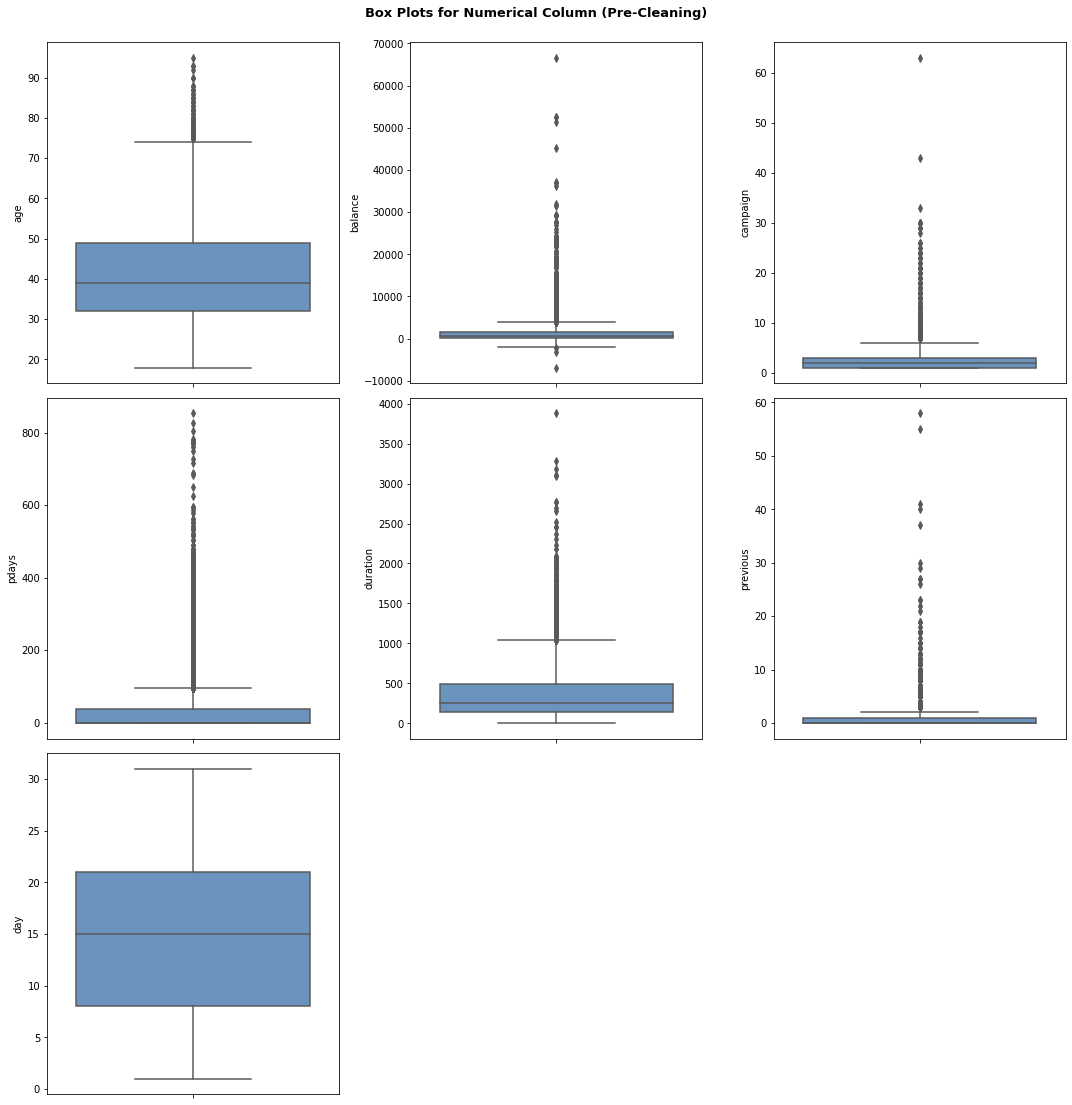

In [24]:
plt.figure(figsize=(15, 15))
n = 3
for i in range(0, len(numerical_columns)):
    plt.subplot(n, math.ceil(len(numerical_columns)/n), i+1)
    sns.boxplot(y=df[numerical_columns[i]], color='#5c94cc', orient='v')
    plt.tight_layout()

plt.suptitle('Box Plots for Numerical Column (Pre-Cleaning)', fontsize=13, y=1.02, fontweight='bold')
plt.show

In [25]:
outlier_stats = []

for i in numerical_columns:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - (IQR * 1.5)
    upper = Q3 + (IQR * 1.5)

    outlier_filter = (df[i] < lower) | (df[i] > upper)
    non_outlier_filter = ~outlier_filter

    lower_whisker = lower
    upper_whisker = upper
    is_outlier = outlier_filter.any()
    n_outlier = outlier_filter.sum()
    non_outlier = non_outlier_filter.sum()
    outlier_percentage = (n_outlier / len(df[i])) * 100

    outlier_stats.append({
        'Column Name': i,
        'Is_outlier': is_outlier,
        'Lower Whisker': lower_whisker,
        'Upper Whisker': upper_whisker, 
        'Outlier': n_outlier,
        'Non Outlier': non_outlier,
        'Outlier Percentage': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_stats)
outlier_df


,Column Name,Is_outlier,Lower Whisker,Upper Whisker,Outlier,Non Outlier,Outlier Percentage
0,age,True,6.500,74.500,121,7697,1.547710
1,balance,True,-2206.625,4016.375,738,7080,9.439754
2,campaign,True,-2.000,6.000,429,7389,5.487337
3,pdays,True,-59.125,95.875,1551,6267,19.838833
4,duration,True,-402.000,1038.000,443,7375,5.666411
5,previous,True,-1.500,2.500,888,6930,11.358404
6,day,False,-11.500,40.500,0,7818,0.000000


**Insight:**
- From the boxplot and summary above, it is observed that only one column, "day," does not have any outliers.
- Outlier handling for the "balance," "previous", and "duration" columns will be done using the Windsorization method and will be scaled using robust scaler.
- The "age" column will be handled through binning, classifying age based on the European Union age classification.
- Outlier handling for the "pdays" column will involve binning and dividing it into quartile periods. The value -1 will be categorized as "never contacted."
- Handling outliers in the "campaign" column will be done using binning with a quantile-based strategy.
- Numeric data, such as "balance", "previous", and "duration", will be rescaled using robust scaling to reduce the effects of skewness while retaining the numerical format.

#### **4. Rare Label**

- **Rare label in categorical columns**

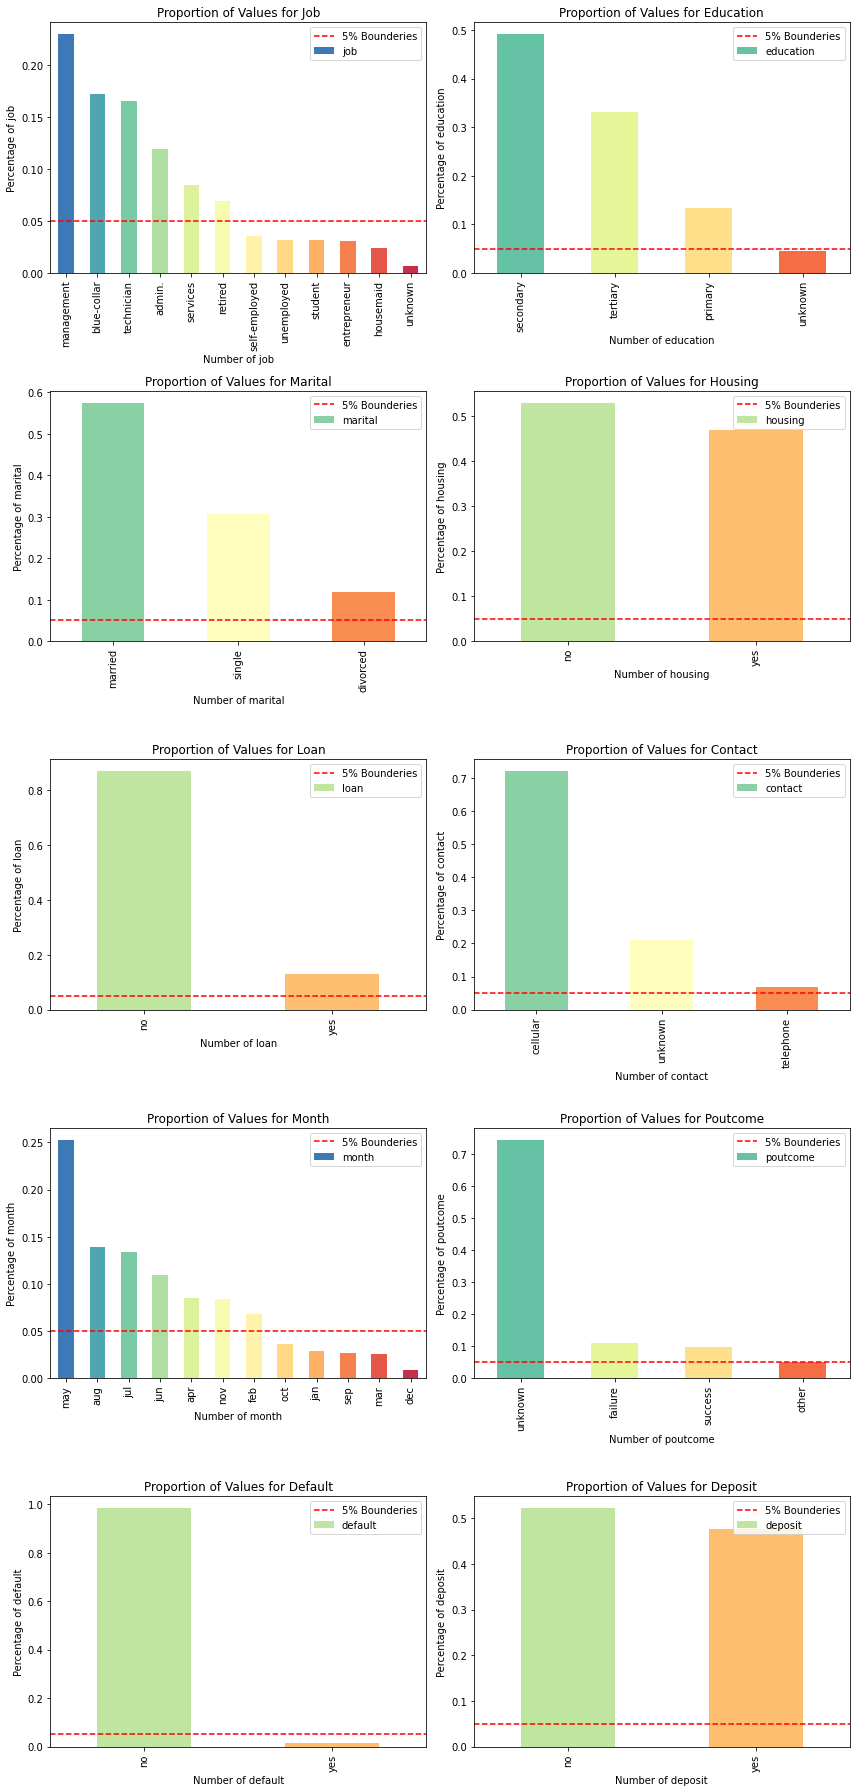

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_proportions(df, columns):

    n_cols = 2
    n_rows = len(columns) // n_cols + (len(columns) % n_cols > 0)
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows*5))
    axes = axes.flatten()  
    
    for ax, column in zip(axes, columns):
        # Calculate the value counts and their proportions
        value_counts = df[column].value_counts(normalize=True).sort_values(ascending=False)
        
        # Create the bar plot
        value_counts.plot(kind='bar', ax=ax, color=sns.color_palette('Spectral_r', len(value_counts)))
        
        # Add a horizontal line at 5%
        ax.axhline(y=0.05, color='red', linestyle='--', label='5% Bounderies')
        
        # Set title and labels
        ax.set_title(f'Proportion of Values for {column.capitalize()}')
        ax.set_xlabel(f'Number of {column}')
        ax.set_ylabel(f'Percentage of {column}')
        
        # Add legend
        ax.legend()

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Define your columns
columns = ['job', 'education', 'marital', 'housing', 'loan', 'contact', 'month', 'poutcome', 'default', 'deposit']

# Example usage with your dataframe
plot_categorical_proportions(df, columns)



**Insight:**

- In the 'job' column, some categories are considered 'rare labels' as they represent less than 5% of the total data. Those columns are : 'self employed', 'enterprenenur', 'housemaid', 'student', 'retired', 'unemployed', 'unknown'
- The 'month' column also has rare labels, particularly in October, January, September, March, and December.
- In the 'default' column, the 'yes' category is a rare label.

**Handling:**
- For the 'job' column:
    - The categories 'self-employed' and 'entrepreneur' will be merged.
    - 'Housemaid' will be included in the 'services' category.
    - 'Student', 'retired', 'unemployed', and 'unknown' will all be grouped under 'unemployed'.
- Regarding the 'month' column, the months will be retained as they represent different time in a year. 
- For the 'default' column the rare label 'yes' will be kept as is, given its significance in representing individuals who have defaulted on payments.

- **Rare label in target**

In [31]:
deposit_counts = df['deposit'].value_counts()

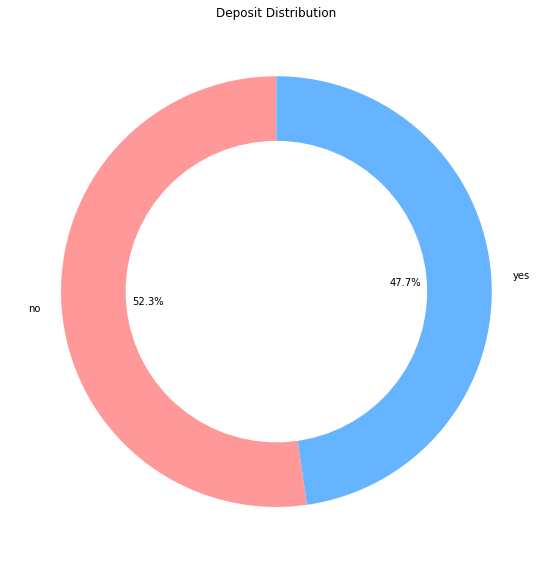

In [32]:
plt.figure(figsize=(8, 8))
plt.pie(deposit_counts, labels=deposit_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Deposit Distribution')

# Draw a circle at the center of pie to make it look like a doughnut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

**Insight:**

- There is an imbalance in the 'deposit' column. The 'yes' value accounts for 47.7%, while the 'no' value accounts for 52.3%.

**Handling:**

- Trying algorithms robust to imbalance.
- Trying balancing methods such as oversampling, undersampling, SMOTE, and NearMiss

#### **5. Multicollinearity**

In [ ]:
df1 = df.copy()
month_mapping = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}
poutcome_mapping = {'unknown': 0, 'other': 1, 'failure': 2, 'success': 3}
binary_mapping = {'yes' : 1, 'no' : 0}


df1['month'] = df1['month'].replace(month_mapping)
df1['poutcome'] = df1['poutcome'].replace(poutcome_mapping)
df1['housing'] = df1['housing'].replace(binary_mapping)
df1['loan'] = df1['loan'].replace(binary_mapping)
df1['deposit'] = df1['deposit'].replace(binary_mapping)
df1['default'] = df1['default'].replace(binary_mapping)

df_encoded = pd.get_dummies(df1, columns=['job', 'contact', 'marital'])

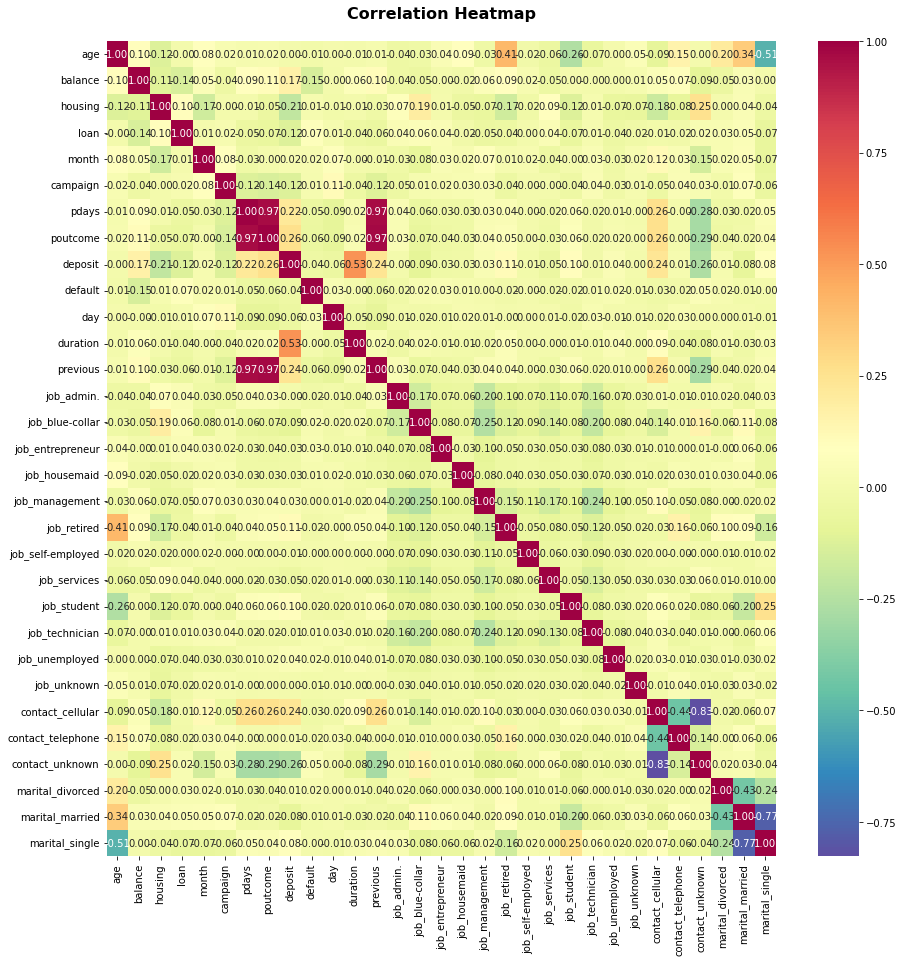

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_encoded.corr(method='spearman'), cmap='Spectral_r', annot=True, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=16, y=1.02, fontweight='bold')
plt.show()

**Insight:**

The dataset reveals several notable correlations between features:

- **Very strong** correlations include:
    - Correlation between 'previous' and both 'pdays' and 'poutcome', with a correlation coefficient of +0.97.
    - Correlation between 'poutcome' and 'pdays', where the correlation is +0.9.
    - Correlation of -0.83 exists between 'contact_cellular' and 'contact_unknown'.
    
- A **strong** negative correlation of -0.77 is observed between 'marital_married' and 'marital_single'.

- **Moderate correlations** include:
    - 'Age' with 'marital_single' and 'job_retired', showing coefficients of -0.51 and +0.41, respectively.
    - Between 'deposit' and 'duration', the correlation is moderately positive at +0.53.

**Handling Approach:**

- Despite these correlations, all mentioned features will be retained for analysis.
- The focus will be on trying models that are not sensitive to multicollinearity. This approach allows the use of all relevant features without the need to discard any due to their interrelationships.
- This strategy aims to leverage the full length of information available in the dataset while employing models best suited to handle multicollinearity.


> **Note**: Feature engineering will be discussed in the third notebook along with the creation of machine learning models.